# Fitting A Gaussian Process

This notebook is a high level guide concerning the basic concepts to fit a Gaussian process model. Fitting Gaussian process models can be very complex and this notebook does not address the many nuances , tips, and tricks to fit such models well. This notebook merely covers the high level concepts.

It is assumed that the reader has an understanding of Bayesian 

There are two philosophies for fitting GPs. The first is by far the easier (but less precise) which is maximum likelihood estimation (MLE). The second is to do inference (either Markov Chain Monte Carlo or Variational Inference). It is always faster to use MLE to fit the kernel parameters, but in practice this often leads to poorer fits for the GP. We walk through a simple example of each method here. 

It may seem that I am using overly simplistic examples to explain the concepts in this notebook. I'm simply trying to reduce the complexity of the models being built so that students can focus on the fitting process.

## Setting Up An Example Problem

In [1]:
# model with Squidward
from squidward.kernels import distance, kernel_base
from squidward import gpr

# useful visualization functions
import gp_viz

# generate example data
import numpy as np

# plot example data
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# generate noisy samples for dataset
samples = 100

# train data
x_train = np.random.uniform(0,15,samples)
noise = np.random.normal(0,250,samples)
y_train = 200 * x_train + noise

# test data
x_test = np.random.uniform(0,15,samples)
noise = np.random.normal(0,250,samples)
y_test = 200 * x_test + noise

# generate noiseless data to plot true mean
x_true = np.linspace(0,15,1000)
y_true = 200 * x_true

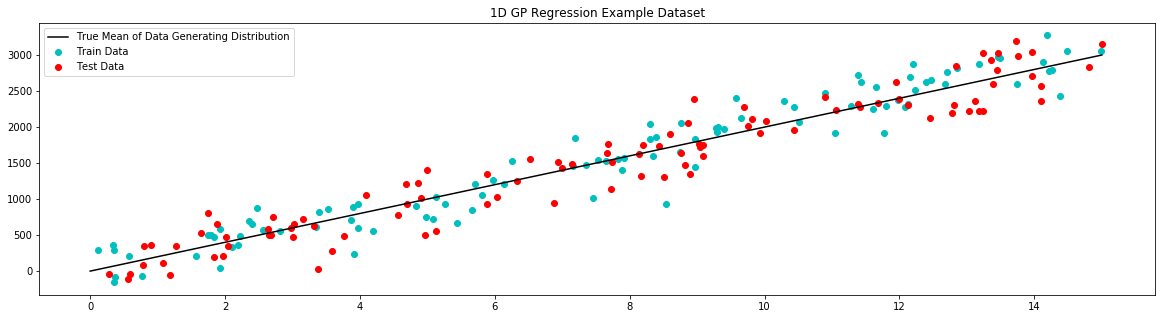

In [3]:
# plot example dataset
plt.figure(figsize=(20,5))
plt.title('1D GP Regression Example Dataset')
plt.scatter(x_train,y_train,label='Train Data', c='c')
plt.scatter(x_test,y_test,label='Test Data', c='r')
plt.plot(x_true,y_true,label='True Mean of Data Generating Distribution', c='k')
plt.legend()
plt.show()

## Maximum Likelihood Estimation

In [8]:
# define loss function for optimizer
def log_likelihood(args):
    c, var_b, var_k, var_l = args[0], args[1], args[2], args[3]
    
    try:
        d = distance.Linear(c, var_b, var_k)
        kernel = kernel_base.Kernel(d, 'k1')
        model = gpr.GaussianProcessInversion(kernel=kernel, var_l=var_l, show_warnings=False)
    
        log_likelihood = model.fit(x_train, y_train).get_posterior_logpdf(x_train)
        
        # the prior / regularizing term
        prior = np.sum(np.array(args)**2)
        
        # log likelihood
        logpdf = log_likelihood + log_prior
        
    except:
        return np.float('inf')

    return log_likelihood + prior 

In [9]:
from scipy.optimize import minimize

# initial starting parameter values
initial_values = [0.0, 10000, 10000, 250**2]

# run optimizer
result = minimize(log_likelihood, initial_values, bounds=((0, None), (0, None), (0, None), (0, None)))

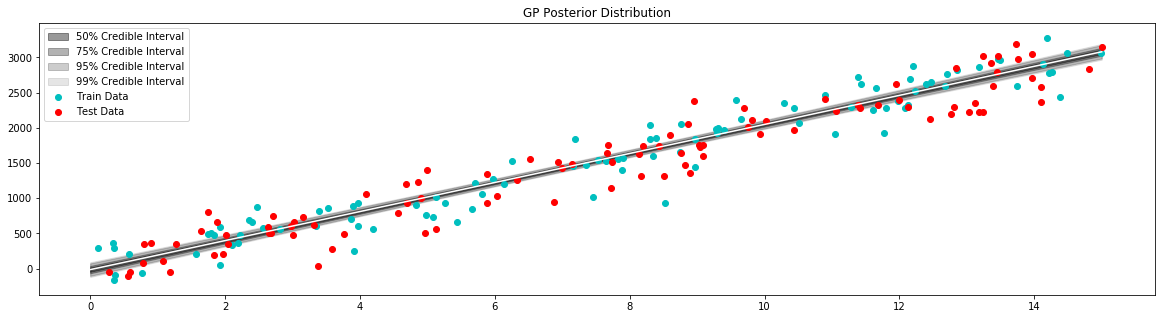

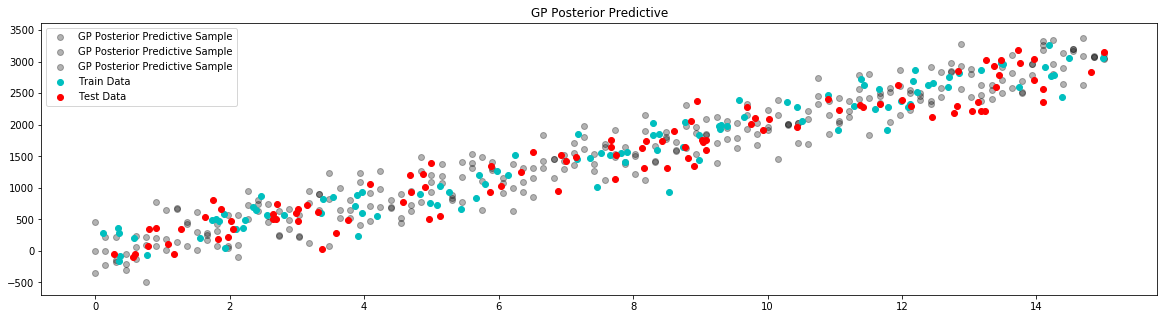

In [11]:
# get optimizer results
results = result.x.tolist()
c, var_b, var_k, var_l = results[0], results[1], results[2], results[3]

# definine a GP based on optimal parameters
d = distance.Linear(c, var_b, var_k)
kernel = kernel_base.Kernel(d, 'k1')
model = gpr.GaussianProcessInversion(kernel=kernel, var_l=var_l, show_warnings=False)
model.fit(x_train, y_train)

# generate data to plot posterior of model
x = np.linspace(0,15,100)

# pull the parameters of the posterior distribution
mean, var = model.get_posterior(x)

# plot posterior of model
plt.figure(figsize=(20,5))
plt.title("GP Posterior Distribution")
gp_viz.regression.plot_1d(x,mean,var[:,0])
plt.scatter(x_train,y_train,label='Train Data', c='c')
plt.scatter(x_test,y_test,label='Test Data', c='r')
plt.legend()
plt.show()

# plot posterior predictive
plt.figure(figsize=(20, 5))
plt.title("GP Posterior Predictive")
for i in range(3):

    posterior_predictive_sample = model.sample_posterior_predictive(x)

    plt.scatter(x, posterior_predictive_sample, label="GP Posterior Predictive Sample", c='k', alpha=0.3)

plt.scatter(x_train,y_train,label='Train Data', c='c')
plt.scatter(x_test,y_test,label='Test Data', c='r')
plt.legend()
plt.show()

## Inference

**This is a toy example!** While inference will provide the full posterior of the GP accounting for uncertainty in the kernel parameters, it is extremely costly computationally. Below I have an illustrative example of how one might go about setting up a metropolis sampler to find the posterior over kernel parameters. I don't recommend using the code below for any actual modeling use case.

If you plan to do inference to find the posterior over kernel parameters for an actual model, I would recommend using a very efficient sampler ,such as a HMC or Slice sampler, to minimize the number of iterations required to get a valid posterior. Even better, you could use variational inference to find an approximation of the posterior over the kernel parameter. 

In [13]:
import progressbar
import scipy.stats as st

# define loss function for optimizer
def log_likelihood(c, var_b, var_k, var_l):
    
    try:
        d = distance.Linear(c, var_b, var_k)
        kernel = kernel_base.Kernel(d, 'k1')
        model = gpr.GaussianProcessInversion(kernel=kernel, var_l=var_l, show_warnings=False)
    
        log_likelihood = model.fit(x_train, y_train).get_posterior_logpdf(x_train)
        
        # the prior / regularizing term
        prior = np.sum(np.array(args)**2)
        
        # log likelihood
        logpdf = log_likelihood + log_prior
        
    except:
        return np.float('inf')

    return log_likelihood + prior 

# the trace of the sampler
trace = {
    'c' : [0.0],
    'var_b' : [69**2],
    'var_k' : [388**2],
    'var_l' : [172**2],
}

# take jsut enough samples to make the point
n_iter = 100

# simple metropolis sampler
progress = progressbar.ProgressBar()
for i in progress(range(n_iter)):
    
    # c step
    
    propose_c = np.random.normal(trace['c'][-1], 100.0)
    
    propose_ll = log_likelihood(propose_c,
                                trace['var_b'][-1],
                                trace['var_k'][-1],
                                trace['var_l'][-1])
    
    current_ll = log_likelihood(trace['c'][-1],
                                trace['var_b'][-1],
                                trace['var_k'][-1],
                                trace['var_l'][-1])
    
    if propose_ll - current_ll >= np.log(np.random.uniform(0, 1, 1)):
        trace['c'].append(propose_c)
    else:
        trace['c'].append(trace['c'][-1])
        
    # var_b step
        
    propose_var_b = np.random.normal(trace['var_b'][-1], 1000.0)
    
    propose_ll = log_likelihood(trace['c'][-1],
                                propose_var_b,
                                trace['var_k'][-1],
                                trace['var_l'][-1])
    
    current_ll = log_likelihood(trace['c'][-1],
                                trace['var_b'][-1],
                                trace['var_k'][-1],
                                trace['var_l'][-1])
    
    if propose_ll - current_ll >= np.log(np.random.uniform(0, 1, 1)):
        trace['var_b'].append(propose_var_b)
    else:
        trace['var_b'].append(trace['var_b'][-1])
        
    # var_k step
        
    propose_var_k = np.random.normal(trace['var_k'][-1], 1000.0)
    
    propose_ll = log_likelihood(trace['c'][-1],
                                trace['var_b'][-1],
                                propose_var_k,
                                trace['var_l'][-1])
    
    current_ll = log_likelihood(trace['c'][-1],
                                trace['var_b'][-1],
                                trace['var_k'][-1],
                                trace['var_l'][-1])
    
    if propose_ll - current_ll >= np.log(np.random.uniform(0, 1, 1)):
        trace['var_k'].append(propose_var_k)
    else:
        trace['var_k'].append(trace['var_k'][-1])
        
    # var_l step
        
    propose_var_l = np.random.normal(trace['var_l'][-1], 1000.0)
    
    propose_ll = log_likelihood(trace['c'][-1],
                                trace['var_b'][-1],
                                trace['var_k'][-1],
                                propose_var_l)
    
    current_ll = log_likelihood(trace['c'][-1],
                                trace['var_b'][-1],
                                trace['var_k'][-1],
                                trace['var_l'][-1])
    
    if propose_ll - current_ll >= np.log(np.random.uniform(0, 1, 1)):
        trace['var_l'].append(propose_var_l)
    else:
        trace['var_l'].append(trace['var_l'][-1])


100% |########################################################################|


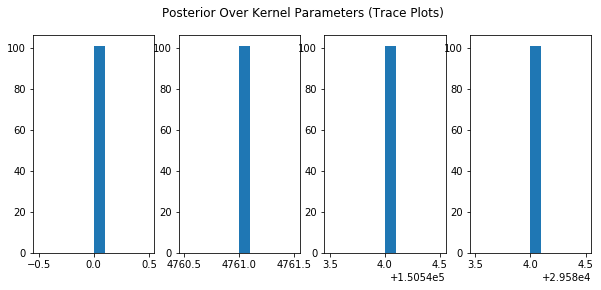

In [14]:
plt.figure(figsize=(10,4))
plt.suptitle("Posterior Over Kernel Parameters (Trace Plots)")
plt.subplot(141)
plt.hist(trace['c'])
plt.subplot(142)
plt.hist(trace['var_b'])
plt.subplot(143)
plt.hist(trace['var_k'])
plt.subplot(144)
plt.hist(trace['var_l'])
plt.show()

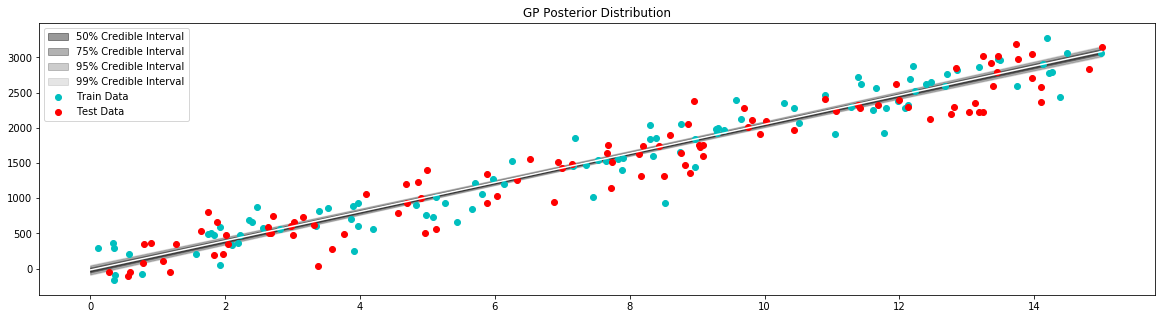

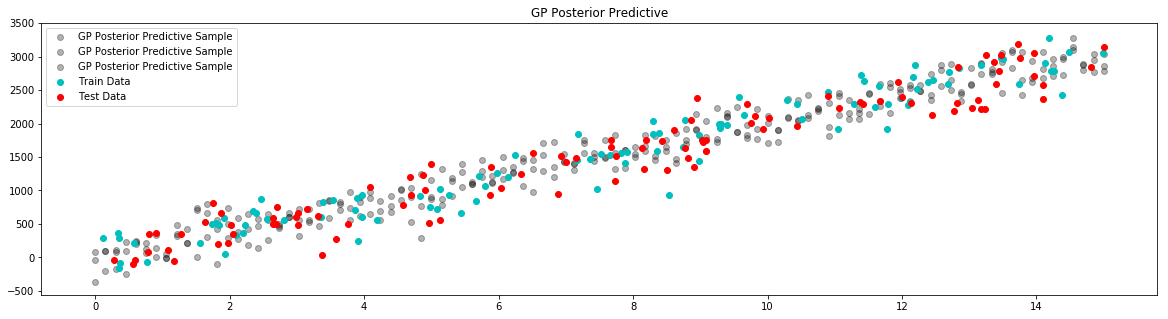

In [16]:
c = np.mean(trace['c'])
var_b = np.mean(trace['var_b'])
var_k = np.mean(trace['var_k'])
var_l = np.mean(trace['var_l'])

# definine a GP based on optimal parameters
d = distance.Linear(c, var_b, var_k)
kernel = kernel_base.Kernel(d, 'k1')
model = gpr.GaussianProcessInversion(kernel=kernel, var_l=var_l, show_warnings=False)
model.fit(x_train, y_train)

# generate data to plot posterior of model
x = np.linspace(0,15,100)

# pull the parameters of the posterior distribution
mean, var = model.get_posterior(x)

# plot posterior of model
plt.figure(figsize=(20,5))
plt.title("GP Posterior Distribution")
gp_viz.regression.plot_1d(x,mean,var[:,0])
plt.scatter(x_train,y_train,label='Train Data', c='c')
plt.scatter(x_test,y_test,label='Test Data', c='r')
plt.legend()
plt.show()

# plot posterior predictive
plt.figure(figsize=(20, 5))
plt.title("GP Posterior Predictive")
for i in range(3):

    posterior_predictive_sample = model.sample_posterior_predictive(x)

    plt.scatter(x, posterior_predictive_sample, label="GP Posterior Predictive Sample", c='k', alpha=0.3)

plt.scatter(x_train,y_train,label='Train Data', c='c')
plt.scatter(x_test,y_test,label='Test Data', c='r')
plt.legend()
plt.show()